# Transfer Learning for Cats and Dogs classification using CNN

In [3]:
train_dir=r"C:\Users\sidre\Desktop\cats_and_dogs_small\train"
valid_dir=r"C:\Users\sidre\Desktop\cats_and_dogs_small\validation"
test_dir=r"C:\Users\sidre\Desktop\cats_and_dogs_small\test"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### We have different images with different specifics: portrait,landscape,different dimensions
## ImageDateGenerator will reshape all of them and bring them to same dimension 

### Generating batches of tensor image data
train_datagen=ImageDataGenerator(rescale=1/255.,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1/255.)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=20,class_mode='binary')
validation_generator=test_datagen.flow_from_directory(valid_dir,target_size=(150,150),batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import VGG16

conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))

58892288/58889256 [==============================] - 80s 1us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
from tensorflow.keras import layers,models
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


# If we don't want to optimize weights of conv_base of VGG16 we need to set
## conv_base.trainable=False

In [20]:
conv_base.trainable=False

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


# Observe that trainable parameters reduced from 16 million to 2.1 billion because of using conv_base.trainable=False

In [22]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

In [23]:
from tensorflow import keras
checkpoint_cb=keras.callbacks.ModelCheckpoint("cnn_vgg_transfer_learning_model-{epoch:02d}.h5")

In [24]:
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=5,
                            validation_data=validation_generator,validation_steps=50,callbacks=[checkpoint_cb]) 
# we can increase the epochs till 100 in this case

Epoch 1/5
100/100 [==============================] - 1151s 12s/step - loss: 0.5279 - acc: 0.7300 - val_loss: 0.3114 - val_acc: 0.8690
Epoch 2/5
100/100 [==============================] - 1119s 11s/step - loss: 0.4279 - acc: 0.8025 - val_loss: 0.2827 - val_acc: 0.8790
Epoch 3/5
100/100 [==============================] - 1101s 11s/step - loss: 0.3805 - acc: 0.8215 - val_loss: 0.2684 - val_acc: 0.8880
Epoch 4/5
100/100 [==============================] - 1117s 11s/step - loss: 0.3591 - acc: 0.8380 - val_loss: 0.2571 - val_acc: 0.8920
Epoch 5/5
100/100 [==============================] - 1115s 11s/step - loss: 0.3547 - acc: 0.8365 - val_loss: 0.2451 - val_acc: 0.9000


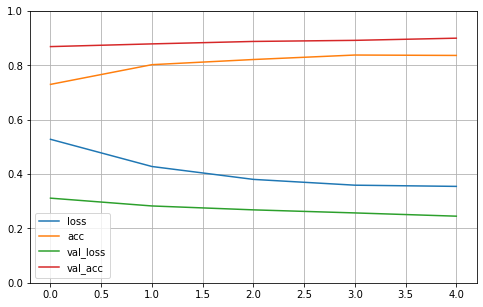

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [26]:
model.save("cat_dog_classifier_transfer_learning.h5")

# Model Evaluation

In [27]:
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(150,150),batch_size=20,class_mode='binary')

model.evaluate_generator(test_generator,steps=50)

Found 1000 images belonging to 2 classes.


[0.26304482251405714, 0.891]

In [28]:
from tensorflow import keras
del model
keras.backend.clear_session()

In [29]:
model=keras.models.load_model("cat_dog_classifier_transfer_learning.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
